<a href="https://colab.research.google.com/github/sarveshjoshi29/CCML_SarveshJoshi/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset

In [ ]:
class BTCDataset(Dataset):
    def __init__(self, file_path, timesteps=30):
        # 1. Load and Preprocess
        df = pd.read_csv(file_path)

        # 2. Feature Engineering (Stationary Features[Indicators])
        df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
        df['log_range'] = np.log(df['High'] / df['Low'])
        df['rel_body'] = (df['Close'] - df['Open']) / (df['High'] - df['Low'] + 1e-8)
        df['log_vol_change'] = np.log(df['Vol'] / df['Vol'].shift(1) + 1e-8)
        df['rsi_norm'] = df['RSI'] / 100.0
        df['macd_rel'] = df['MACD'] / (df['Close'] + 1e-8)

        df = df.dropna().reset_index(drop=True)


        self.feature_cols = ['log_return', 'log_range', 'rel_body', 'log_vol_change', 'rsi_norm', 'macd_rel']

        #4. Adding context cols i.e date/time so that model incorporates cyclicity
        self.context_cols = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'min_sin','min_cos','hour_sin','hour_cos',]


        self.closing_prices = df['Close']
        self.scaler = StandardScaler()
        df[self.feature_cols] = self.scaler.fit_transform(df[self.feature_cols])

        all_needed_cols = self.feature_cols + self.context_cols
        self.data = df[all_needed_cols].astype(np.float32).values


        self.feat_idx = [all_needed_cols.index(c) for c in self.feature_cols]
        self.ctx_idx = [all_needed_cols.index(c) for c in self.context_cols]
        self.target_idx = all_needed_cols.index('log_return')

        self.timesteps = timesteps

    def __len__(self):
        return len(self.data) - self.timesteps

    def __getitem__(self, idx):
        # x_seq shape: (timesteps, num_features)
        x_seq = self.data[idx : idx + self.timesteps, self.feat_idx]

        # Context: at idx + timesteps
        x_ctx = self.data[idx + self.timesteps, self.ctx_idx]

        # Target: log_return at idx + timesteps
        y = self.data[idx + self.timesteps, self.target_idx]

        return (torch.tensor(x_seq, dtype=torch.float32),
                torch.tensor(x_ctx, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32))


full_dataset = BTCDataset('/content/drive/MyDrive/DOGE.csv', timesteps=30)

# Chronological Split into train/test (80% Train, 20% Test)
train_size = int(len(full_dataset) * 0.8)
indices = list(range(len(full_dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model Structure

feature_cols -> 1D Conv -> 2 Stacked LSTMs (with dropout in between) -> Multihead Self Attention -> Concatenate attention output with context data -> MLP Layer -> 2 Heads (mu , sigma) -> Custom Loss function



In [ ]:
class Model(nn.Module):
    def __init__(self,timesteps,num_features,context_dim = 8):
        super().__init__()
        self.timesteps = timesteps
        self.num_features = num_features

        self.conv_layer_params = {"out_channels" : 32, "kernel_size" : 3}
        self.LSTM_params = {"LSTM1": 80, "LSTM2" : 64}

        self.conv1d = nn.Conv1d(in_channels=num_features,
                             out_channels=self.conv_layer_params['out_channels'],
                             kernel_size=self.conv_layer_params['kernel_size'],
                             padding='same')

        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(input_size = self.conv_layer_params['out_channels'],batch_first = True,hidden_size = self.LSTM_params["LSTM1"])
        self.dropout1 = nn.Dropout(0.2)
        self.LSTM2 = nn.LSTM(input_size = self.LSTM_params['LSTM1'], batch_first = True,hidden_size = self.LSTM_params["LSTM2"])

        self.num_heads = 4
        self.attention = nn.MultiheadAttention(embed_dim=self.LSTM_params["LSTM2"],
                                               num_heads=self.num_heads,
                                               batch_first=True)
        self.final_dim = self.LSTM_params["LSTM2"] + context_dim
        self.mlp = nn.Sequential(
            nn.Linear(self.final_dim, 32),
            nn.Mish(), # Mish is better for VAEs
            nn.Dropout(0.1)
        )
        self.mu_head = nn.Linear(32, 1)
        self.sigma_head = nn.Linear(32, 1)

    def forward(self,x,context_data):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x,_ = self.LSTM1(x)
        x = self.dropout1(x)
        x,_ = self.LSTM2(x)
        attn_output, attn_weights = self.attention(x, x, x)
        last_timestep = attn_output[:, -1, :]

        combined = torch.cat((last_timestep, context_data), dim=1)
        hidden = self.mlp(combined)
        mu = self.mu_head(hidden)

        # IMPORTANT: Sigma must ALWAYS be positive. So We use softplus to ensure it stays > 0.
        sigma = F.softplus(self.sigma_head(hidden)) + 1e-6
        return mu, sigma , attn_weights




In [ ]:
def custom_loss(mu, sigma, target,lambd = 0.5):
    variance = sigma**2
    return torch.mean(0.5 * torch.log(variance) + 0.5 * (target - mu )**2 / variance + lambd* (target - mu)**2 )

In [ ]:
def train(model, train_loader,epochs = 40,lr = 1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(device)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    print(f"Starting training on {device}...")
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        curr_loss = 0
        for x_seq, x_ctx, y in train_loader:
            #Move data to GPU/CPU
            x_seq, x_ctx, y = x_seq.to(device), x_ctx.to(device), y.to(device)
            y = y.view(-1, 1)

            optimizer.zero_grad()

            # Forward pass
            mu, sigma , attn_weights = model(x_seq, x_ctx)

            # Custom Loss function
            loss = custom_loss(mu, sigma,y)

            # Backprop
            loss.backward()

            # Clip gradients (prevents NaN on CPU)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            total_loss += loss.item()
            curr_loss = loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    return model



In [ ]:
model = Model(timesteps = 30,num_features = 6)
train(model,train_loader)

cuda
Starting training on cuda...
Epoch 1/40 | Loss: 0.743352
Epoch 2/40 | Loss: 0.715440
Epoch 3/40 | Loss: 0.711488
Epoch 4/40 | Loss: 0.702670
Epoch 5/40 | Loss: 0.696867
Epoch 6/40 | Loss: 0.693657
Epoch 7/40 | Loss: 0.695266
Epoch 8/40 | Loss: 0.688419
Epoch 9/40 | Loss: 0.686896
Epoch 10/40 | Loss: 0.687493
Epoch 11/40 | Loss: 0.682812
Epoch 12/40 | Loss: 0.678465
Epoch 13/40 | Loss: 0.676912
Epoch 14/40 | Loss: 0.675132
Epoch 15/40 | Loss: 0.670189
Epoch 16/40 | Loss: 0.670366
Epoch 17/40 | Loss: 0.660177
Epoch 18/40 | Loss: 0.656146
Epoch 19/40 | Loss: 0.653714
Epoch 20/40 | Loss: 0.653656
Epoch 21/40 | Loss: 0.644760
Epoch 22/40 | Loss: 0.638761
Epoch 23/40 | Loss: 0.634831
Epoch 24/40 | Loss: 0.636578
Epoch 25/40 | Loss: 0.625294
Epoch 26/40 | Loss: 0.618026
Epoch 27/40 | Loss: 0.609891
Epoch 28/40 | Loss: 0.605177
Epoch 29/40 | Loss: 0.594502
Epoch 30/40 | Loss: 0.597866
Epoch 31/40 | Loss: 0.583976
Epoch 32/40 | Loss: 0.578945
Epoch 33/40 | Loss: 0.566124
Epoch 34/40 | Loss

Model(
  (conv1d): Conv1d(6, 32, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (LSTM1): LSTM(32, 80, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (LSTM2): LSTM(80, 64, batch_first=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=72, out_features=32, bias=True)
    (1): Mish()
    (2): Dropout(p=0.1, inplace=False)
  )
  (mu_head): Linear(in_features=32, out_features=1, bias=True)
  (sigma_head): Linear(in_features=32, out_features=1, bias=True)
)

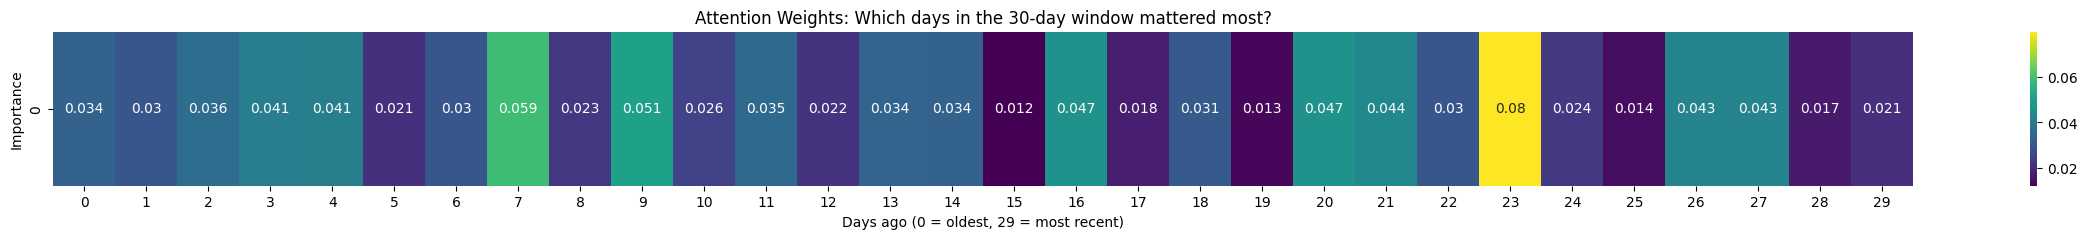

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_weights(attn_weights, window_idx=0):
    """
    Plots the attention weights for a given sample in the batch.
    """
    # We take the weights for the LAST timestep (what the model used for its final summary)
    weights = attn_weights[window_idx, -1, :].cpu().detach().numpy()

    plt.figure(figsize=(30, 2))
    sns.heatmap(weights.reshape(1, -1), annot=True, cmap='viridis', cbar=True)
    plt.title("Attention Weights: Which days in the 30-day window mattered most?")
    plt.xlabel("Days ago (0 = oldest, 29 = most recent)")
    plt.ylabel("Importance")
    plt.show()


model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

myus = []
sigmas = []
with torch.no_grad():
    x_seq, x_ctx, y = next(iter(train_loader))
    mu, sigma, attn_weights = model(x_seq.to(device), x_ctx.to(device))
    myus.append(mu)
    sigmas.append(sigma)
    # Plot the first item in the batch
    plot_attention_weights(attn_weights, window_idx=0)

In [ ]:
def predict_and_evaluate(model, test_loader, scaler): # Removed 'device' parameter from signature
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Determine device here
    model.to(device) # Move the model to the determined device
    model.eval()
    all_mu, all_sigma, all_y = [], [], []
    total_test_loss = 0

    # Scaling parameters for inverse transform (log_return is index 0)
    mean_ret = scaler.mean_[0]
    std_ret = scaler.scale_[0]

    with torch.no_grad():
        for x_seq, x_ctx, y in test_loader:
            x_seq, x_ctx, y = x_seq.to(device), x_ctx.to(device), y.to(device)
            y = y.view(-1, 1) # Match (Batch, 1)

            mu, sigma, _ = model(x_seq, x_ctx)

            # Pass dirn to the loss function
            loss = custom_loss(mu, sigma, y)
            total_test_loss += loss.item()

            # Move to CPU and inverse scale back to real percentage returns
            mu_real = (mu.cpu().numpy() * std_ret) + mean_ret
            sigma_real = sigma.cpu().numpy() * std_ret
            y_real = (y.cpu().numpy() * std_ret) + mean_ret

            all_mu.extend(mu_real)
            all_sigma.extend(sigma_real)
            all_y.extend(y_real)

    avg_loss = total_test_loss / len(test_loader)
    print(f"Final Test Loss: {avg_loss:.6f}")

    return np.array(all_mu), np.array(all_sigma), np.array(all_y)


# Update the call to receive the four outputs
mu_preds, sigma_preds, y_true = predict_and_evaluate(model, test_loader, full_dataset.scaler)

Final Test Loss: 0.259727


In [ ]:
mu_preds.mean()

np.float64(7.338360321627287e-06)

In [ ]:
sigma_preds.mean()

np.float64(0.0018848846375005485)

In [ ]:
def check_probabilistic_calibration(mu, sigma, target):
    # Calculate the absolute difference between predicted mean and actual value
    diff = np.abs(target - mu)

    # Check how many points fall within 1 and 2 standard deviations
    within_1std = np.mean(diff <= sigma)
    within_2std = np.mean(diff <= 2 * sigma)

    print("-" * 30)
    print("CALIBRATION RESULTS")
    print("-" * 30)
    print(f"Within 1 Sigma: {within_1std:.2%} (Expected: ~68.2%)")
    print(f"Within 2 Sigma: {within_2std:.2%} (Expected: ~95.4%)")

    # Interpretation
    if within_1std < 0.60:
        print("\nResult: Under-confident. Actual moves are larger than predicted sigma.")
    elif within_1std > 0.80:
        print("\nResult: Over-confident. Sigma is too wide; model is too cautious.")
    else:
        print("\nResult: Well-calibrated! The model understands its own uncertainty.")

check_probabilistic_calibration(mu_preds, sigma_preds, y_true)
indices = test_dataset.indices
prices = np.array(test_dataset.dataset.closing_prices[indices]).flatten()

------------------------------
CALIBRATION RESULTS
------------------------------
Within 1 Sigma: 68.22% (Expected: ~68.2%)
Within 2 Sigma: 92.04% (Expected: ~95.4%)

Result: Well-calibrated! The model understands its own uncertainty.


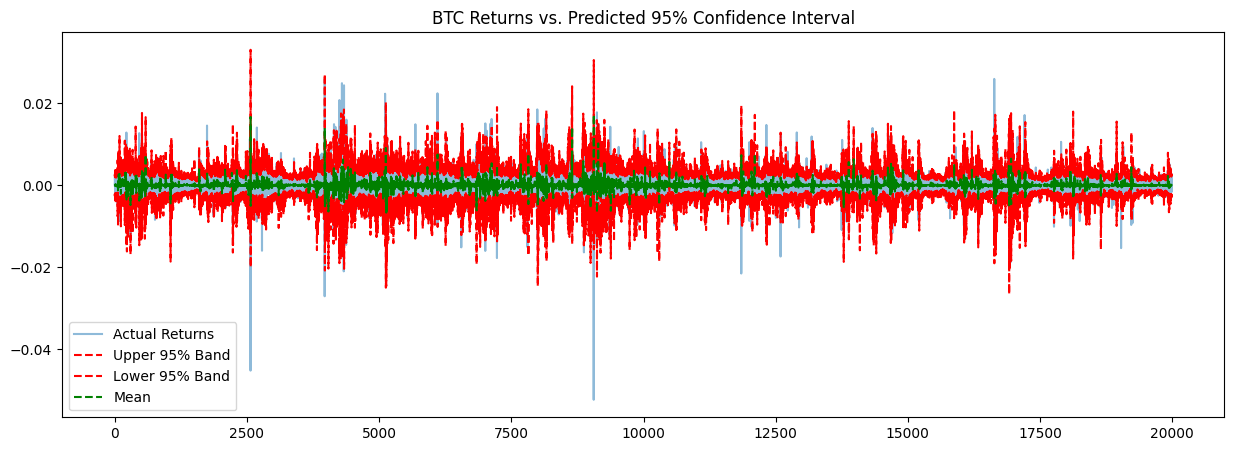

In [ ]:
def plot_predicted_band_of_returns(y_true, mu_preds, sigma_preds):

    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='Actual Returns', alpha=0.5)
    plt.plot(mu_preds + 2*sigma_preds, color='r', linestyle='--', label='Upper 95% Band')
    plt.plot(mu_preds - 2*sigma_preds, color='r', linestyle='--', label='Lower 95% Band')
    plt.plot(mu_preds, color = 'g',linestyle = '--', label = 'Mean')
    plt.title("BTC Returns vs. Predicted 95% Confidence Interval")
    plt.legend()
    plt.show()
plot_predicted_band_of_returns(y_true, mu_preds, sigma_preds)

In [ ]:
import numpy as np

def calculate_sharpe(mu, sigma, risk_free_rate=0, annualized_factor=np.sqrt(12*70*24)):
    '''Calculates step-wise and overall Sharpe ratios from log-normal parameters.
        Annualized factor is set to sqrt(12*70*24) assuming 5 min data over 70 days (~20k timesteps).
    '''
    # 1. Convert parameters of LogNormal distribution to find mean and std of returns
    # E[R] = exp(mu + 0.5 * sigma^2) - 1
    # var[R] = [exp(sigma^2) - 1] * exp(2*mu + sigma^2)
    exp_return = np.exp(mu + 0.5 * sigma**2) - 1
    exp_risk = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))

    # 2. Calculate Step-wise Sharpe (Signal-to-Noise Ratio)
    step_sharpe = (exp_return - risk_free_rate) / exp_risk

    # 3. Calculate Overall Sharpe
    # We take the mean of returns and the quadratic mean (RMS) of the risk
    mean_return = np.mean(exp_return)
    mean_risk = np.sqrt(np.mean(exp_risk**2))

    overall_sharpe = ((mean_return - risk_free_rate) / mean_risk) * annualized_factor

    return {
        "step_sharpe": step_sharpe,
        "overall_sharpe": overall_sharpe,
        "expected_return_avg": mean_return
    }

# Example usage with your notebook variables:
results = calculate_sharpe(mu_preds, sigma_preds)
print(f"Overall Sharpe: {np.mean(results['overall_sharpe']):.4f}",)

Overall Sharpe: 0.6544


Max Conviction: 4.4215
Min Conviction: -1.0721
Average Abs Conviction: 0.1171


/tmp/ipython-input-4190522094.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


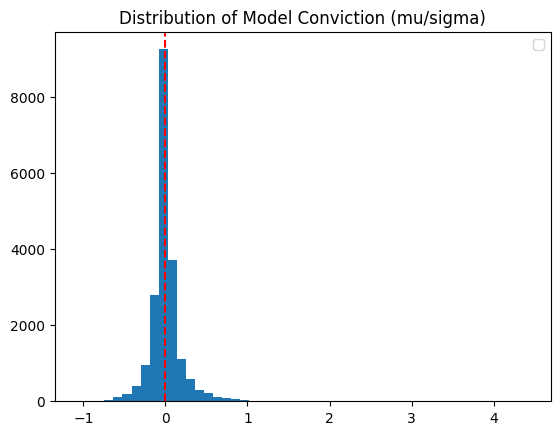

In [ ]:
def plot_conviction_distribution(mu_preds, sigma_preds):
    '''Plots the distribution of model conviction (mu/sigma).'''

    # Convert parameters of LogNormal distribution
    temp1 = np.exp(mu_preds + 0.5 * sigma_preds**2) - 1
    temp2 = np.sqrt((np.exp(sigma_preds**2) - 1) * np.exp(2*mu_preds + sigma_preds**2))
    conviction = temp1/temp2
    print(f"Max Conviction: {conviction.max():.4f}")
    print(f"Min Conviction: {conviction.min():.4f}")
    print(f"Average Abs Conviction: {np.abs(conviction).mean():.4f}")

    plt.hist(conviction, bins=50)
    plt.title("Distribution of Model Conviction (mu/sigma)")
    plt.axvline(0.0, color='r', linestyle='--')
    plt.legend()
    plt.show()
plot_conviction_distribution(mu_preds, sigma_preds)

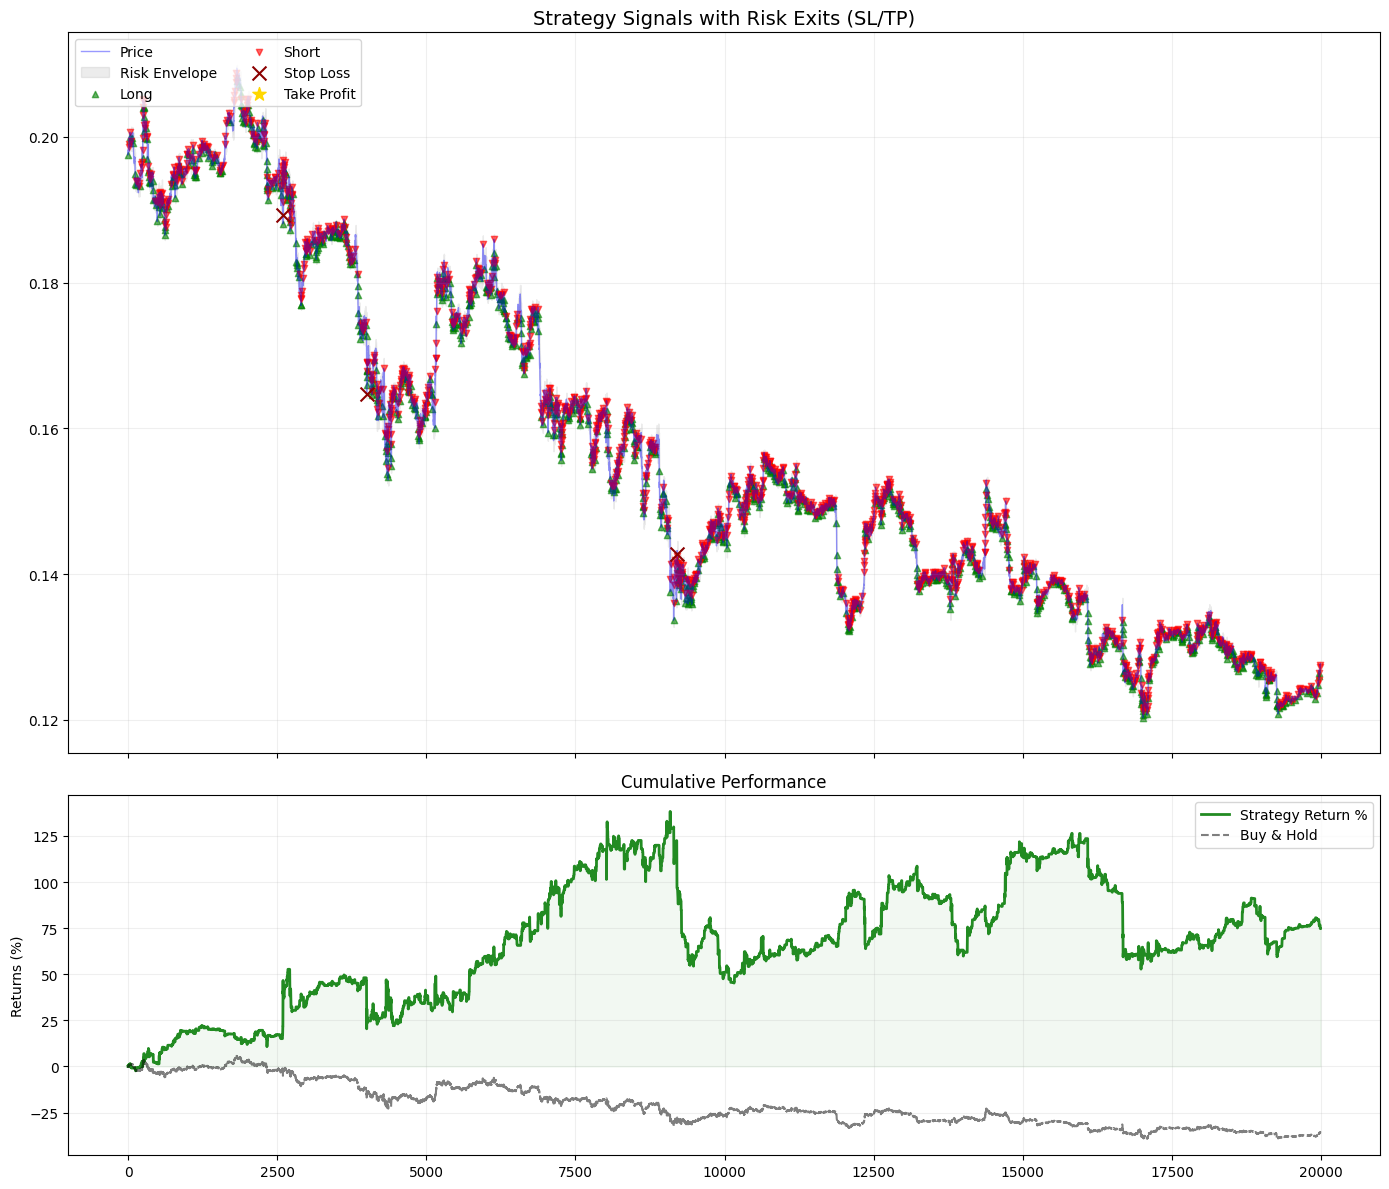

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_volatility_band_backtest(mu, sigma, prices, initial_wealth=500,
                                     n_sigma=1.75, risk_target=0.1, leverage_cap=4.0,
                                     stop_loss_pct=0.03, take_profit_pct=0.08):
    """
    Mean Reversion strategy with Black-Scholes inspired bands,
    Risk-weighted position sizing, and SL/TP exits.
    """
    # Conversion of LogNormal parameters
    mu_arith = np.exp(mu + 0.5 * sigma**2).flatten() - 1
    sigma_arith = np.sqrt(np.exp(sigma**2) - 1).flatten() * np.exp(2*mu + sigma**2).flatten()

    df = pd.DataFrame({
        'price': prices.flatten(),
        'sigma': sigma_arith.flatten(),
        'mu' : mu_arith.flatten()
    })

    # Bands from previous day's data defined by n_sigma
    df['upper_band'] = df['price'] * (1 + (n_sigma * df['sigma']))
    df['lower_band'] = df['price'] * (1 - (n_sigma * df['sigma']))

    # State variables
    df['units_held'] = 0.0
    df['total_wealth'] = float(initial_wealth)
    df['exit_type'] = "" # To store "SL", "TP", or "Mean"

    current_cash = initial_wealth
    current_units = 0.0
    entry_price = 0.0

    for i in range(1, len(df)):
        curr_p = df.loc[i, 'price']
        upper = df.loc[i-1, 'upper_band']
        lower = df.loc[i-1, 'lower_band']

        current_wealth = current_cash + (current_units * curr_p)

        # Calculate PnL if in position
        pnl = 0.0
        if current_units > 0: pnl = (curr_p - entry_price) / entry_price
        elif current_units < 0: pnl = (entry_price - curr_p) / entry_price

        # --- SIGNAL LOGIC ---
        reason = ""
        # 1. Exit Logic (Priority) {Stop Loss / Take Profit}
        if current_units != 0 and pnl <= -stop_loss_pct:
            signal, reason = 0, "SL"
        elif current_units != 0 and pnl >= take_profit_pct:
            signal, reason = 0, "TP"
        # 2. Entry Logic {Mean Reversion}
        elif curr_p < lower:
            signal = 1
        elif curr_p > upper:
            signal = -1
        else:
            signal = 0
            if current_units != 0: reason = "Mean"

        #3. POSITION SIZING
        if signal != 0:
            target_weight = risk_target / (df.loc[i, 'sigma'] + 1e-9)
            capped_weight = np.clip(target_weight, 0, leverage_cap)
            target_units = (current_wealth * capped_weight * signal) / curr_p
            if current_units == 0: entry_price = curr_p # Lock entry price
        else:
            target_units = 0.0
            entry_price = 0.0

        # 4. Execute
        units_to_trade = target_units - current_units
        current_cash -= units_to_trade * curr_p
        current_units = target_units

        # 5. Record trades
        df.loc[i, 'units_held'] = current_units
        df.loc[i, 'total_wealth'] = current_cash + (current_units * curr_p)
        df.loc[i, 'exit_type'] = reason

    df['strat_cum_ret'] = (df['total_wealth'] / initial_wealth) - 1
    df['bh_cum_ret'] = (df['price'] / df['price'].iloc[0]) - 1

    plot_performance(df, initial_wealth)
    return df

def plot_performance(df, initial_wealth):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # 1. Price, Bands, and Signals
    ax1.plot(df.index, df['price'], label='Price', color='blue', alpha=0.4, lw=1)
    ax1.fill_between(df.index, df['lower_band'].shift(1), df['upper_band'].shift(1), color='gray', alpha=0.15, label='Risk Envelope')

    # Identify entries and exits
    longs = df[df['units_held'] > 0]
    shorts = df[df['units_held'] < 0]
    sl_exits = df[df['exit_type'] == "SL"]
    tp_exits = df[df['exit_type'] == "TP"]

    ax1.scatter(longs.index, longs['price'], marker='^', color='green', s=20, label='Long', alpha=0.6)
    ax1.scatter(shorts.index, shorts['price'], marker='v', color='red', s=20, label='Short', alpha=0.6)

    # Plot SL and TP points
    ax1.scatter(sl_exits.index, sl_exits['price'], marker='x', color='darkred', s=100, label='Stop Loss', zorder=5)
    ax1.scatter(tp_exits.index, tp_exits['price'], marker='*', color='gold', s=100, label='Take Profit', zorder=5)

    ax1.set_title("Strategy Signals with Risk Exits (SL/TP)", fontsize=14)
    ax1.legend(loc='upper left', ncol=2)
    ax1.grid(True, alpha=0.2)

    # 2. Cumulative Returns
    ax2.plot(df.index, df['strat_cum_ret'] * 100, color='forestgreen', label='Strategy Return %', lw=2)
    ax2.plot(df.index, df['bh_cum_ret'] * 100, color='black', linestyle='--', alpha=0.5, label='Buy & Hold')
    ax2.fill_between(df.index, 0, df['strat_cum_ret'] * 100, color='green', alpha=0.05)
    ax2.set_title("Cumulative Performance", fontsize=12)
    ax2.set_ylabel("Returns (%)")
    ax2.legend()
    ax2.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()


results = run_volatility_band_backtest(mu_preds, sigma_preds, prices, stop_loss_pct=0.03, take_profit_pct=0.1)